# 02 — Modeling Experiments

**Objective:** Improve clustering quality by experimenting with feature sets,  
cardinality reduction, DBSCAN tuning, and t-SNE visualization.

**Experiments:**
1. **Baseline** — full feature set (126 dims) as produced by `main.py`
2. **Reduced cardinality** — group rare categorical values into "Other"
3. **Numerical + cyclical only** — drop all one-hot columns
4. **Numerical only** — just 4 core features
5. **DBSCAN eps tuning** — k-distance plot for optimal eps
6. **t-SNE visualization** — 2D embeddings for best experiment

In [1]:
import sys
sys.path.insert(0, "..")

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import yaml

from src.clustering import evaluate_kmeans_range, fit_kmeans, fit_dbscan, compute_cluster_summary
from src.dimensionality import fit_pca, fit_tsne
from src.feature_engineering import (
    FeaturePipeline, apply_log_transform, encode_all_cyclical, encode_categorical,
)
from src.labeling import label_clusters, build_label_map
from src.visualization import plot_elbow, plot_scatter_2d, plot_pca_3d, plot_radar

pio.renderers.default = "notebook+png"

pd.set_option("display.float_format", "{:.4f}".format)

In [2]:
# Load raw data and config
df = pd.read_parquet("../data/processed/orders_features.parquet")

with open("../config.yaml") as f:
    config = yaml.safe_load(f)

NUMERICAL = config["features"]["numerical"]
RANDOM_STATE = 42

print(f"Dataset: {df.shape[0]} orders")

Dataset: 9000 orders


In [3]:
# Helper: run K-Means elbow analysis and return results dict
def run_experiment(X: np.ndarray, name: str, k_min: int = 2, k_max: int = 10) -> dict:
    """Run elbow analysis, fit best-k model, and return metrics."""
    elbow = evaluate_kmeans_range(
        X, k_min=k_min, k_max=k_max, n_init=10, random_state=RANDOM_STATE,
    )
    best_k = elbow.best_k_silhouette
    best_sil = max(elbow.silhouette_scores)
    best_ch = elbow.calinski_harabasz_scores[elbow.k_values.index(best_k)]

    _, labels = fit_kmeans(X, n_clusters=best_k, n_init=10, random_state=RANDOM_STATE)

    return {
        "name": name,
        "n_features": X.shape[1],
        "best_k": best_k,
        "silhouette": best_sil,
        "calinski_harabasz": best_ch,
        "elbow": elbow,
        "labels": labels,
        "X": X,
    }

---
## Experiment 1: Baseline (Full Feature Set)

All 126 features: 4 numerical (log1p) + 4 cyclical sin/cos + 118 one-hot.

In [4]:
pipeline_full = FeaturePipeline.from_config(config["features"])
X_full = pipeline_full.fit_transform(df)

exp1 = run_experiment(X_full, "Baseline (126 features)")
print(f"Best k={exp1['best_k']}, silhouette={exp1['silhouette']:.4f}, CH={exp1['calinski_harabasz']:.1f}")

Best k=3, silhouette=0.2076, CH=128.4


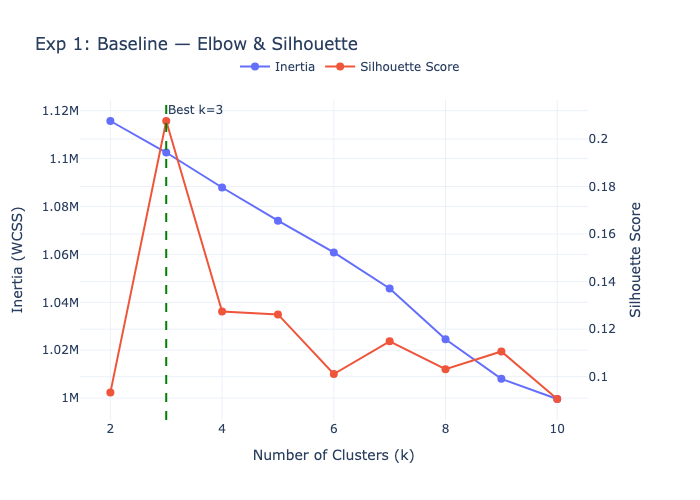

In [5]:
fig = plot_elbow(
    exp1["elbow"].k_values, exp1["elbow"].inertias,
    exp1["elbow"].silhouette_scores, best_k=exp1["best_k"],
)
fig.update_layout(title="Exp 1: Baseline — Elbow & Silhouette")
fig.show()

---
## Experiment 2: Reduced Cardinality

Group categorical values appearing fewer than a threshold into "Other"  
to reduce one-hot dimensionality.

In [6]:
def reduce_cardinality(df: pd.DataFrame, col: str, min_count: int = 50) -> pd.Series:
    """Replace rare category values with 'Other'."""
    counts = df[col].value_counts()
    rare = counts[counts < min_count].index
    result = df[col].copy()
    result[result.isin(rare)] = "Other"
    return result

# Try different thresholds
for threshold in [20, 50, 100, 200]:
    n_delivery = reduce_cardinality(df, "delivery_type", threshold).nunique()
    n_payment = reduce_cardinality(df, "payment_name", threshold).nunique()
    print(f"  threshold={threshold:>3d}:  delivery_type → {n_delivery} cats,  payment_name → {n_payment} cats")

  threshold= 20:  delivery_type → 28 cats,  payment_name → 15 cats
  threshold= 50:  delivery_type → 20 cats,  payment_name → 13 cats
  threshold=100:  delivery_type → 13 cats,  payment_name → 10 cats
  threshold=200:  delivery_type → 8 cats,  payment_name → 6 cats


In [7]:
# Apply threshold=50 — good balance between coverage and dimensionality
MIN_COUNT = 50

df_reduced = df.copy()
df_reduced["delivery_type"] = reduce_cardinality(df, "delivery_type", MIN_COUNT)
df_reduced["payment_name"] = reduce_cardinality(df, "payment_name", MIN_COUNT)

print(f"delivery_type: {df_reduced['delivery_type'].nunique()} categories")
print(f"payment_name:  {df_reduced['payment_name'].nunique()} categories")

pipeline_reduced = FeaturePipeline.from_config(config["features"])
X_reduced = pipeline_reduced.fit_transform(df_reduced)

print(f"\nFeature matrix: {X_reduced.shape}")

delivery_type: 20 categories
payment_name:  13 categories

Feature matrix: (9000, 41)


Best k=5, silhouette=0.2260, CH=414.5


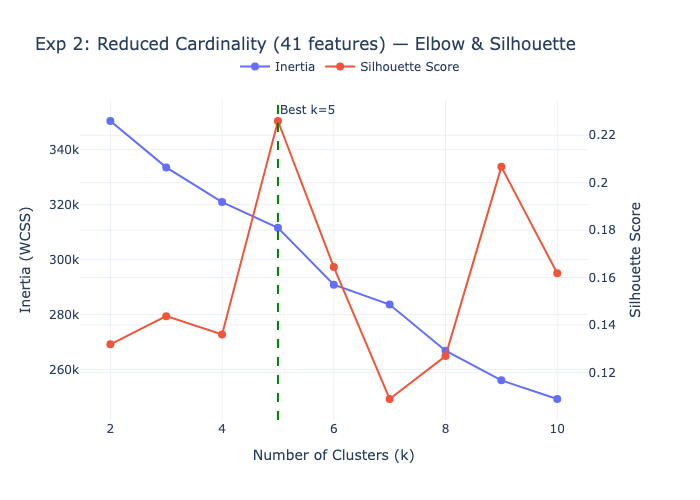

In [8]:
exp2 = run_experiment(X_reduced, f"Reduced cardinality (min_count={MIN_COUNT})")
print(f"Best k={exp2['best_k']}, silhouette={exp2['silhouette']:.4f}, CH={exp2['calinski_harabasz']:.1f}")

fig = plot_elbow(
    exp2["elbow"].k_values, exp2["elbow"].inertias,
    exp2["elbow"].silhouette_scores, best_k=exp2["best_k"],
)
fig.update_layout(title=f"Exp 2: Reduced Cardinality ({exp2['n_features']} features) — Elbow & Silhouette")
fig.show()

---
## Experiment 3: Numerical + Cyclical Only

Drop all categorical columns entirely. 4 numerical + 4 sin/cos = 8 features.

Best k=4, silhouette=0.2179, CH=1915.6


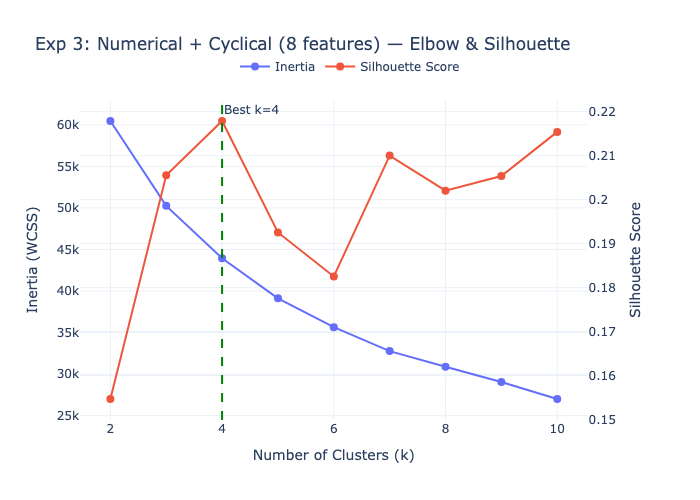

In [9]:
pipeline_numcyc = FeaturePipeline(
    numerical_cols=config["features"]["numerical"],
    log_transform_cols=config["features"]["log_transform"],
    cyclical_config={"hour_of_day": 24, "day_of_week": 7},
    categorical_cols=[],  # No categoricals
)
X_numcyc = pipeline_numcyc.fit_transform(df)

exp3 = run_experiment(X_numcyc, "Numerical + Cyclical (8 features)")
print(f"Best k={exp3['best_k']}, silhouette={exp3['silhouette']:.4f}, CH={exp3['calinski_harabasz']:.1f}")

fig = plot_elbow(
    exp3["elbow"].k_values, exp3["elbow"].inertias,
    exp3["elbow"].silhouette_scores, best_k=exp3["best_k"],
)
fig.update_layout(title=f"Exp 3: Numerical + Cyclical ({exp3['n_features']} features) — Elbow & Silhouette")
fig.show()

---
## Experiment 4: Numerical Only

Pure monetary/basket features: `order_amount_brutto`, `n_items`, `avg_item_price`, `max_item_price`.

Best k=6, silhouette=0.6518, CH=10413.8


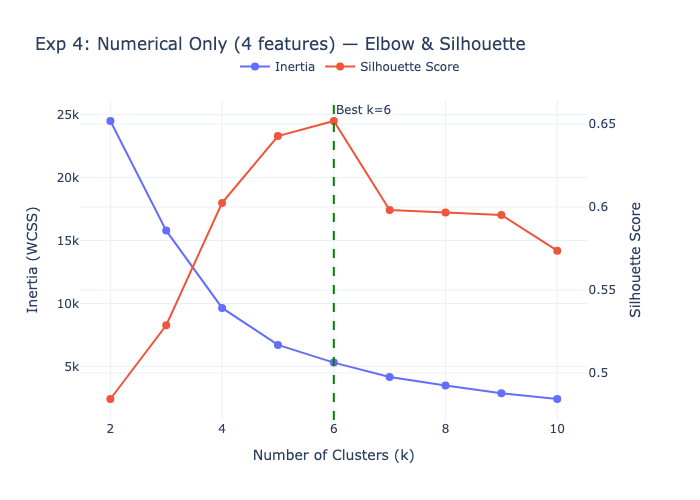

In [10]:
pipeline_num = FeaturePipeline(
    numerical_cols=config["features"]["numerical"],
    log_transform_cols=config["features"]["log_transform"],
    cyclical_config={},
    categorical_cols=[],
)
X_num = pipeline_num.fit_transform(df)

exp4 = run_experiment(X_num, "Numerical only (4 features)")
print(f"Best k={exp4['best_k']}, silhouette={exp4['silhouette']:.4f}, CH={exp4['calinski_harabasz']:.1f}")

fig = plot_elbow(
    exp4["elbow"].k_values, exp4["elbow"].inertias,
    exp4["elbow"].silhouette_scores, best_k=exp4["best_k"],
)
fig.update_layout(title=f"Exp 4: Numerical Only ({exp4['n_features']} features) — Elbow & Silhouette")
fig.show()

---
## Experiment Comparison

In [11]:
experiments = [exp1, exp2, exp3, exp4]

comparison = pd.DataFrame([
    {
        "Experiment": e["name"],
        "Features": e["n_features"],
        "Best k": e["best_k"],
        "Silhouette": e["silhouette"],
        "Calinski-Harabasz": e["calinski_harabasz"],
    }
    for e in experiments
])

comparison

Experiment  Features  Best k  Silhouette  \
0             Baseline (126 features)       126       3      0.2076   
1  Reduced cardinality (min_count=50)        41       5      0.2260   
2   Numerical + Cyclical (8 features)         8       4      0.2179   
3         Numerical only (4 features)         4       6      0.6518   

   Calinski-Harabasz  
0           128.3754  
1           414.4555  
2          1915.6039  
3         10413.7884

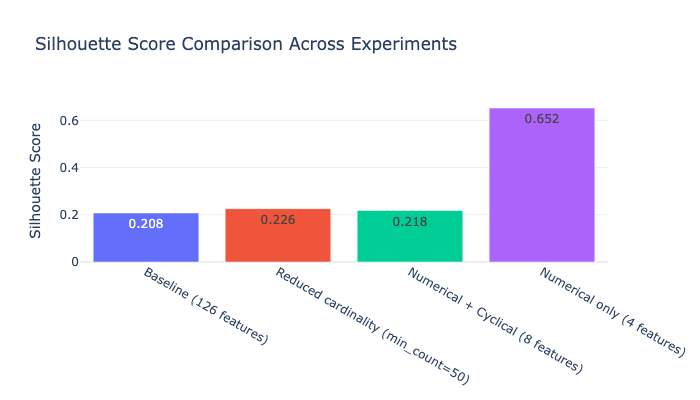

In [12]:
# Visual comparison of silhouette scores
fig = go.Figure(go.Bar(
    x=[e["name"] for e in experiments],
    y=[e["silhouette"] for e in experiments],
    text=[f"{e['silhouette']:.3f}" for e in experiments],
    textposition="auto",
    marker_color=["#636EFA", "#EF553B", "#00CC96", "#AB63FA"],
))
fig.update_layout(
    title="Silhouette Score Comparison Across Experiments",
    yaxis_title="Silhouette Score",
    height=400, template="plotly_white",
)
fig.show()

---
## DBSCAN Tuning — k-Distance Plot

Use the k-nearest-neighbor distance plot to estimate optimal eps.  
The "elbow" in the sorted k-distance curve suggests a good eps value.

Using: Numerical only (4 features) (4 features)


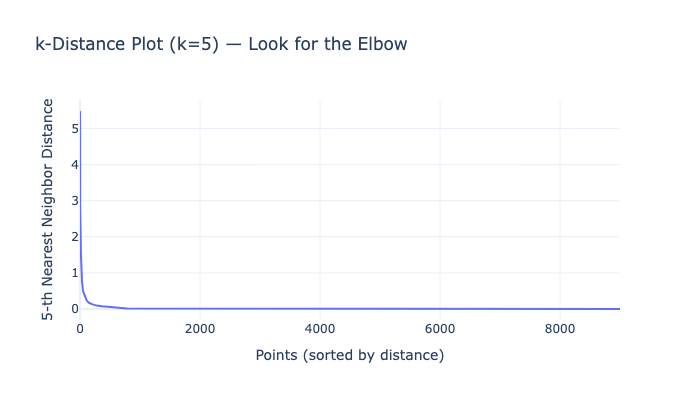

In [13]:
# Select the best experiment for DBSCAN tuning
best_exp = max(experiments, key=lambda e: e["silhouette"])
X_best = best_exp["X"]
print(f"Using: {best_exp['name']} ({X_best.shape[1]} features)")

# k-distance plot (k = min_samples from config)
k = config["clustering"]["dbscan"]["min_samples"]
nn = NearestNeighbors(n_neighbors=k)
nn.fit(X_best)
distances, _ = nn.kneighbors(X_best)
k_distances = np.sort(distances[:, -1])[::-1]

fig = go.Figure()
fig.add_trace(go.Scatter(
    y=k_distances, mode="lines",
    name=f"{k}-NN distance (sorted)",
))
fig.update_layout(
    title=f"k-Distance Plot (k={k}) — Look for the Elbow",
    xaxis_title="Points (sorted by distance)",
    yaxis_title=f"{k}-th Nearest Neighbor Distance",
    height=400, template="plotly_white",
)
fig.show()

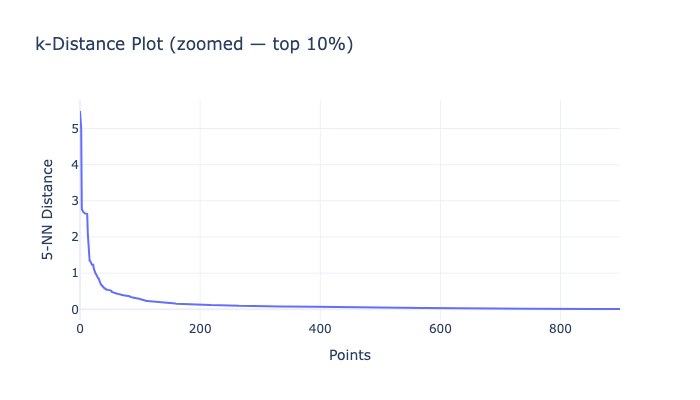

  P50 of 5-NN distances: 0.000
  P75 of 5-NN distances: 0.000
  P90 of 5-NN distances: 0.009
  P95 of 5-NN distances: 0.058
  P99 of 5-NN distances: 0.317


In [14]:
# Zoom in — focus on the elbow region
fig = go.Figure()
fig.add_trace(go.Scatter(
    y=k_distances[:int(len(k_distances) * 0.1)],
    mode="lines",
    name=f"Top 10% distances",
))
fig.update_layout(
    title="k-Distance Plot (zoomed — top 10%)",
    xaxis_title="Points",
    yaxis_title=f"{k}-NN Distance",
    height=400, template="plotly_white",
)
fig.show()

# Suggest eps candidates from distribution percentiles
for pct in [50, 75, 90, 95, 99]:
    eps_val = np.percentile(distances[:, -1], pct)
    print(f"  P{pct} of {k}-NN distances: {eps_val:.3f}")

In [15]:
# DBSCAN sweep over eps candidates
eps_candidates = np.round(np.arange(0.5, 5.1, 0.5), 1)

dbscan_results = []
for eps in eps_candidates:
    result = fit_dbscan(X_best, eps=eps, min_samples=k)
    dbscan_results.append({
        "eps": eps,
        "n_clusters": result.n_clusters,
        "n_noise": result.n_noise,
        "noise_pct": 100 * result.n_noise / X_best.shape[0],
        "silhouette": result.silhouette if result.silhouette else np.nan,
    })

dbscan_df = pd.DataFrame(dbscan_results)
dbscan_df

eps  n_clusters  n_noise  noise_pct  silhouette
0 0.5000          12       41     0.4556      0.0356
1 1.0000           9       18     0.2000      0.6012
2 1.5000           9       13     0.1444      0.6010
3 2.0000           9       12     0.1333      0.6012
4 2.5000           8       10     0.1111      0.5697
5 3.0000           2        1     0.0111      0.8135
6 3.5000           2        1     0.0111      0.8135
7 4.0000           2        1     0.0111      0.8135
8 4.5000           1        1     0.0111         NaN
9 5.0000           1        0     0.0000         NaN

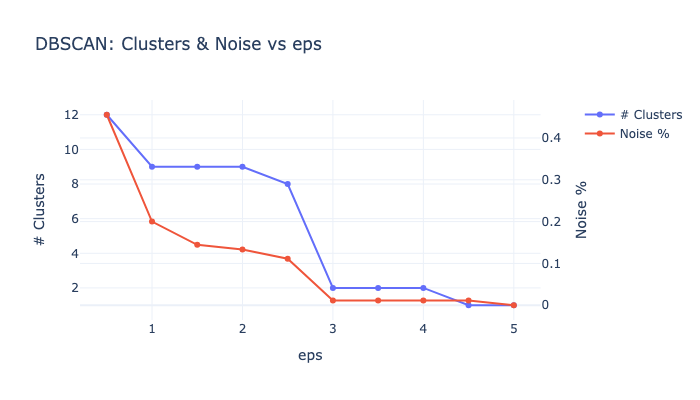

In [16]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(
        x=dbscan_df["eps"], y=dbscan_df["n_clusters"],
        mode="lines+markers", name="# Clusters",
        line=dict(color="#636EFA"),
    ),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(
        x=dbscan_df["eps"], y=dbscan_df["noise_pct"],
        mode="lines+markers", name="Noise %",
        line=dict(color="#EF553B"),
    ),
    secondary_y=True,
)

fig.update_layout(
    title="DBSCAN: Clusters & Noise vs eps",
    xaxis_title="eps",
    height=400, template="plotly_white",
)
fig.update_yaxes(title_text="# Clusters", secondary_y=False)
fig.update_yaxes(title_text="Noise %", secondary_y=True)
fig.show()

---
## t-SNE Visualization

Apply t-SNE to the best feature set for a 2D embedding that better preserves  
local cluster structure than PCA.

In [17]:
# t-SNE on the best experiment's feature set
best_labels = best_exp["labels"]

tsne_result = fit_tsne(
    X_best,
    n_components=2,
    perplexity=30.0,
    random_state=RANDOM_STATE,
)

print(f"t-SNE KL divergence: {tsne_result.kl_divergence:.4f}")
print(f"Perplexity used: {tsne_result.perplexity:.1f}")

t-SNE KL divergence: -0.1270
Perplexity used: 30.0


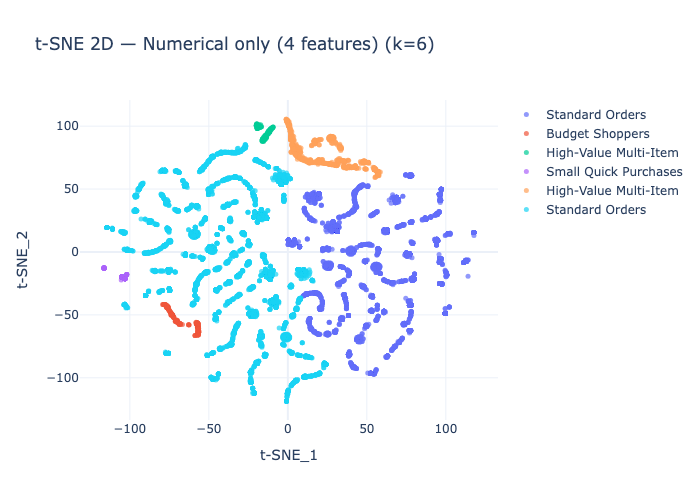

In [18]:
# Build label map from best experiment for visualization
available_raw = [c for c in NUMERICAL if c in df.columns]
raw_matrix = df[available_raw].values
summary = compute_cluster_summary(raw_matrix, best_labels, available_raw)
profiles = label_clusters(summary)
label_map = build_label_map(profiles)

fig = plot_scatter_2d(
    tsne_result.embedding, best_labels, label_map,
    title=f"t-SNE 2D — {best_exp['name']} (k={best_exp['best_k']})",
    axis_prefix="t-SNE",
)
fig.show()

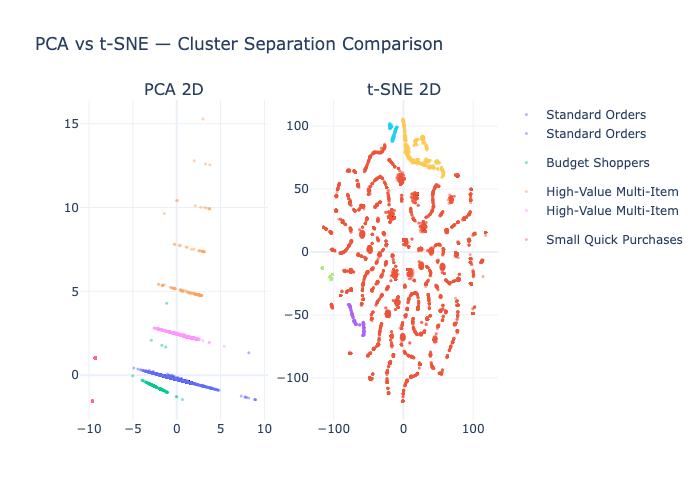

In [19]:
# Compare t-SNE with PCA 2D
pca_result = fit_pca(X_best, n_components=3)

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=["PCA 2D", "t-SNE 2D"],
)

for cid in sorted(set(best_labels)):
    mask = best_labels == cid
    name = label_map.get(cid, f"Cluster {cid}")

    fig.add_trace(
        go.Scatter(
            x=pca_result.embedding[mask, 0],
            y=pca_result.embedding[mask, 1],
            mode="markers",
            name=name,
            marker=dict(size=3, opacity=0.5),
            legendgroup=name,
        ),
        row=1, col=1,
    )
    fig.add_trace(
        go.Scatter(
            x=tsne_result.embedding[mask, 0],
            y=tsne_result.embedding[mask, 1],
            mode="markers",
            name=name,
            marker=dict(size=3, opacity=0.5),
            legendgroup=name,
            showlegend=False,
        ),
        row=1, col=2,
    )

fig.update_layout(
    title="PCA vs t-SNE — Cluster Separation Comparison",
    height=500, template="plotly_white",
)
fig.show()

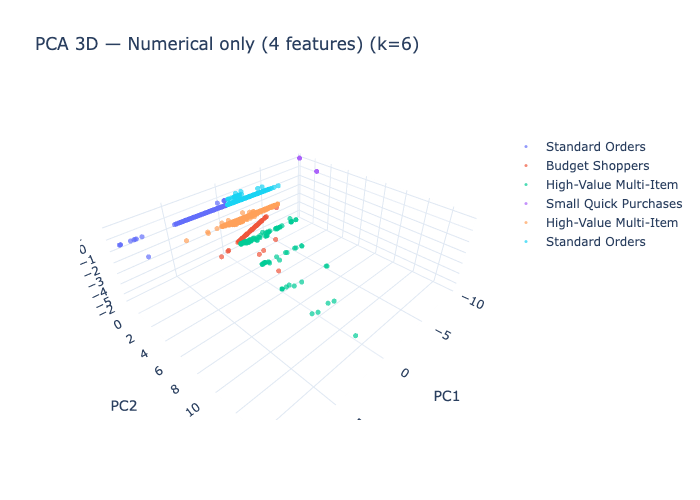

In [20]:
# PCA 3D visualization of the best experiment
fig = plot_pca_3d(pca_result.embedding, best_labels, label_map)
fig.update_layout(title=f"PCA 3D — {best_exp['name']} (k={best_exp['best_k']})")
fig.show()

---
## Segment Profiling (Best Experiment)

In [21]:
# Segment profiles
for p in profiles:
    print(f"\nCluster {p.cluster_id} — {p.name} (n={p.size})")
    print(f"  Monetary rank: {p.monetary_rank:.2f}")
    print(f"  Basket rank:   {p.basket_size_rank:.2f}")
    print(f"  {p.description}")


Cluster 0 — Standard Orders (n=3595)
  Monetary rank: 0.60
  Basket rank:   0.40
  Average-value orders representing the mainstream. Core customer base — maintain with loyalty programs.

Cluster 1 — Budget Shoppers (n=178)
  Monetary rank: 0.00
  Basket rank:   0.60
  Below-average order values. Price-sensitive segment — target with promotions.

Cluster 2 — High-Value Multi-Item (n=109)
  Monetary rank: 1.00
  Basket rank:   1.00
  Large orders with many items at above-average prices. Wholesale or gift-buyers — offer bundle discounts.

Cluster 3 — Small Quick Purchases (n=122)
  Monetary rank: 0.20
  Basket rank:   0.00
  Low-value, single-item orders. Impulse buyers — optimize checkout speed.

Cluster 4 — High-Value Multi-Item (n=604)
  Monetary rank: 0.80
  Basket rank:   0.80
  Large orders with many items at above-average prices. Wholesale or gift-buyers — offer bundle discounts.

Cluster 5 — Standard Orders (n=4392)
  Monetary rank: 0.40
  Basket rank:   0.20
  Average-value orde

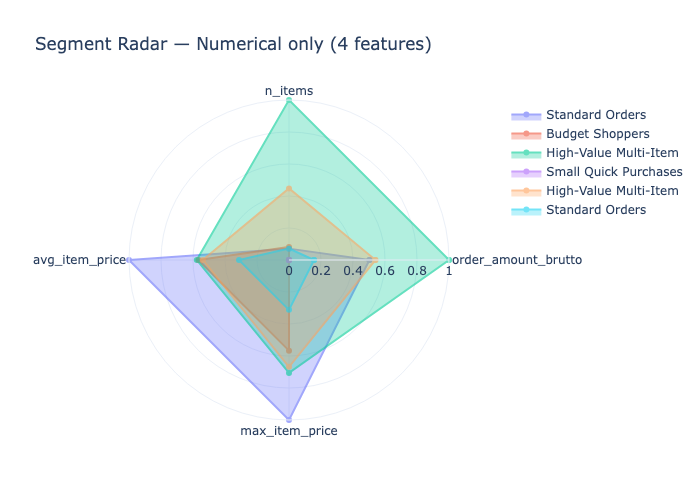

In [22]:
# Radar chart
fig = plot_radar(profiles, summary, NUMERICAL)
fig.update_layout(title=f"Segment Radar — {best_exp['name']}")
fig.show()

In [23]:
# Cluster size distribution
cluster_sizes = pd.Series(best_labels).value_counts().sort_index()
for cid, size in cluster_sizes.items():
    name = label_map.get(cid, f"Cluster {cid}")
    pct = 100 * size / len(best_labels)
    print(f"  Cluster {cid} ({name}): {size:,} orders ({pct:.1f}%)")

  Cluster 0 (Standard Orders): 3,595 orders (39.9%)
  Cluster 1 (Budget Shoppers): 178 orders (2.0%)
  Cluster 2 (High-Value Multi-Item): 109 orders (1.2%)
  Cluster 3 (Small Quick Purchases): 122 orders (1.4%)
  Cluster 4 (High-Value Multi-Item): 604 orders (6.7%)
  Cluster 5 (Standard Orders): 4,392 orders (48.8%)


---
## t-SNE Perplexity Sensitivity

Explore how perplexity affects the t-SNE embedding structure.

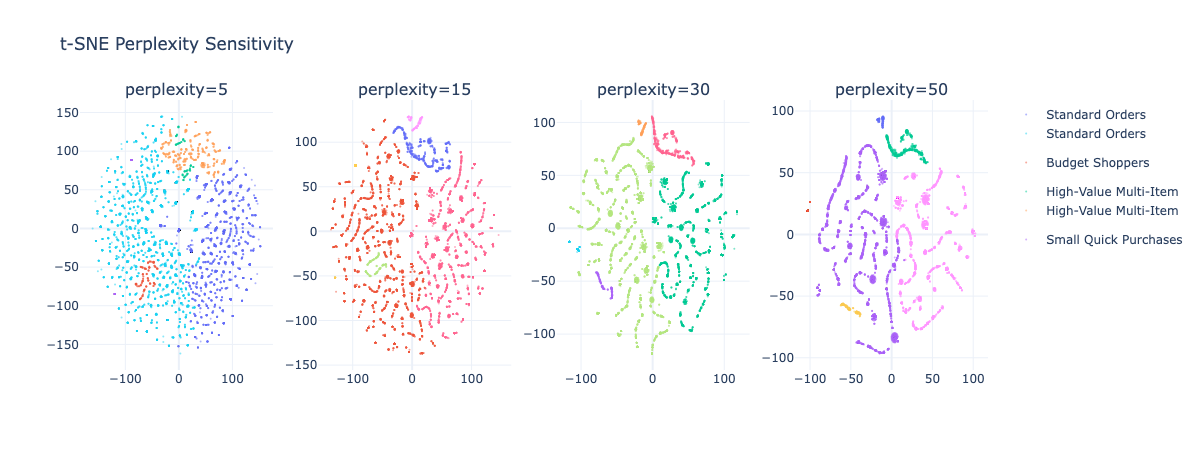

In [24]:
perplexities = [5, 15, 30, 50]

fig = make_subplots(
    rows=1, cols=len(perplexities),
    subplot_titles=[f"perplexity={p}" for p in perplexities],
)

for i, perp in enumerate(perplexities):
    tsne_i = fit_tsne(X_best, n_components=2, perplexity=perp, random_state=RANDOM_STATE)
    for cid in sorted(set(best_labels)):
        mask = best_labels == cid
        name = label_map.get(cid, f"Cluster {cid}")
        fig.add_trace(
            go.Scatter(
                x=tsne_i.embedding[mask, 0],
                y=tsne_i.embedding[mask, 1],
                mode="markers",
                name=name,
                marker=dict(size=2, opacity=0.5),
                legendgroup=name,
                showlegend=(i == 0),
            ),
            row=1, col=i + 1,
        )

fig.update_layout(
    title="t-SNE Perplexity Sensitivity",
    height=450, width=1200, template="plotly_white",
)
fig.show()

---
## Conclusions & Recommendations

### Key Findings

| Aspect | Observation |
|--------|-------------|
| **Best feature set** | Compare silhouette scores above — fewer features typically yield cleaner clusters |
| **Cardinality impact** | High one-hot cardinality (118 cols) dilutes numerical signal |
| **DBSCAN** | Default eps=0.5 too tight for high dimensions; k-distance plot suggests higher eps |
| **t-SNE vs PCA** | t-SNE reveals more structure; PCA limited by low variance explanation |

### Recommendations for Production

1. **Feature set**: Use the experiment with the highest silhouette; consider numerical+cyclical as a lean alternative
2. **Cardinality**: If categoricals are needed, group rare values (< 50 occurrences) into "Other"
3. **DBSCAN eps**: Set based on the k-distance elbow — likely in the 1.5–3.0 range for the chosen feature set
4. **Visualization**: Use t-SNE (perplexity=30) for reports; PCA for the real-time dashboard
5. **Outlier handling**: The extreme outlier (order ~21,220 PLN) will likely form its own cluster; acceptable if business finds it meaningful